In [1]:
!pip install tensorflow

import numpy as np
import nibabel as nib # nifty files read
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
print("Number of GPUs available : ", len(tf.config.list_physical_devices('GPU')))

tf.test.gpu_device_name()

Number of GPUs available :  1


'/device:GPU:0'

### ***Image Data Generator***

In [4]:
# https://youtu.be/PNqnLbzdxwQ
"""
Custom data generator to work with BraTS2020 dataset.
Can be used as a template to create your own custom data generators. 
No image processing operations are performed here, just load data from local directory
in batches. 
"""

#from tifffile import imsave, imread
import os
import numpy as np


def load_img(MRI_images_directory, MRI_images_list):

    images = []
    ground_truth_list = []

    for i, image_name in enumerate(MRI_images_list):    
        if (image_name.split('.')[1] == 'npz'):
            
            image = np.load(MRI_images_directory+image_name)

            MRI_image = image['a']
            
            Ground_truth = image['b']
                      
            images.append(MRI_image[:,:,0:144])

            ground_truth_list.append(Ground_truth[:,:,0:144])

            pass
        
        pass

    images = np.array(images)
    ground_truth_array = np.array(ground_truth_list)
    
    return(images,ground_truth_array)




def imageLoader(MRI_images_directory, MRI_images_list, batch_size):

    L = len(MRI_images_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X,Y = load_img(MRI_images_directory, MRI_images_list[batch_start:limit])
            #Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   # batch_start = batch_start + batch_size
            batch_end += batch_size

############################################

### ***3D UNET Image Segmentation Model***

In [5]:
# https://youtu.be/ScdCQqLtnis
"""
@author: Sreenivas Bhattiprolu
Converted my standard 2D Unet to 3D. 
"""

!pip install Keras
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    #model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(240, 240, 144, 4, 6)
print(model.input_shape)
print(model.output_shape)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
(None, 240, 240, 144, 4)
(None, 240, 240, 144, 6)


### ***Creating Batches Using Image data Generator***

In [12]:
training_MRI_images_directory = '/content/drive/MyDrive/NPZ files/train/'

training_images_names = os.listdir(training_MRI_images_directory)


validation_MRI_images_directory = '/content/drive/MyDrive/NPZ files/validation/'

validation_images_names = os.listdir(validation_MRI_images_directory)


print("Training images :",len(training_images_names))
print("Validation Images :",len(validation_images_names))

#

training_images_names_list = training_images_names
validation_images_names_list = validation_images_names

brats_list = []
subacute_list = []
acute_list = []

for npz in training_images_names:

  if 'brats' in npz:

    brats_list.append(npz)

    pass

  if 'SISS' in npz or 'siss' in npz:

    subacute_list.append(npz)

    pass

  if 'SPES' in npz or 'spes' in npz:

    acute_list.append(npz)

    pass

  pass

print("\n")
print('Number of brats images : ', len(brats_list))
print('Number of acute images : ', len(acute_list))
print('Number of subacute images : ', len(subacute_list))




Training images : 412
Validation Images : 105


Number of brats images :  228
Number of acute images :  96
Number of subacute images :  88


### ***MRI Image Visualization***

(1, 240, 240, 144, 4)
(1, 240, 240, 144, 6)


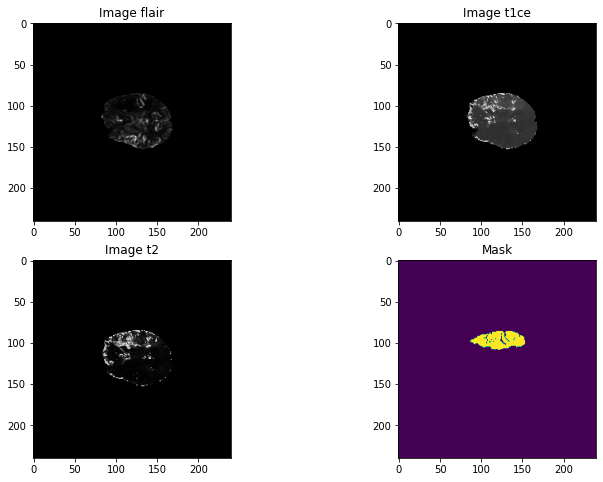

In [ ]:
batch_size = 1
train_image_data_generator = imageLoader(MRI_images_directory=training_MRI_images_directory,MRI_images_list=training_images_names_list,batch_size=batch_size)

for i in range(2):
  
  if i > 0:

    del X,Y

    pass
  X,Y = train_image_data_generator.__next__()

  pass

print(X.shape)
print(Y.shape)

MRI_image = X[0]
Ground_truth = Y[0]

final_ground_truth = np.argmax(Ground_truth,axis=3)

n_slice = 81

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(MRI_image[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(MRI_image[:,:,n_slice, 3], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(MRI_image[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(final_ground_truth[:,:,n_slice])
plt.title('Mask')
plt.show()

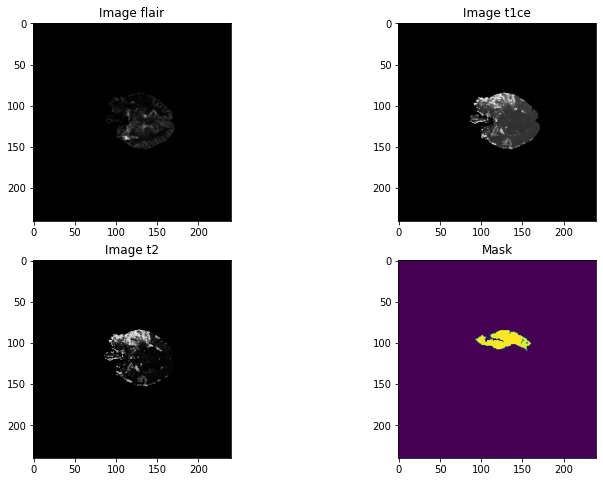

In [ ]:
# Augmentation


def flip3D(X, y):
    """
    Flip the 3D image respect one of the 3 axis chosen randomly
    """
    #choice = np.random.randint(3)
    choice = 2
    if choice == 0: # flip on x
        X_flip, y_flip = X[::-1, :, :, :], y[::-1, :, :]
    if choice == 1: # flip on y
        X_flip, y_flip = X[:, ::-1, :, :], y[:, ::-1, :]
    if choice == 2: # flip on z
        X_flip, y_flip = X[:, :, ::-1, :], y[:, :, ::-1]
        
    return X_flip, y_flip


####################################################################################



new_MRI_image, new_final_ground_truth = flip3D(MRI_image, final_ground_truth)

n_slice = 69

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(new_MRI_image[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(new_MRI_image[:,:,n_slice, 3], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(new_MRI_image[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(new_final_ground_truth[:,:,n_slice])
plt.title('Mask')
plt.show()


### ***IMPORTING KERAS BACKEND FOR USING KERAS FUNCTIONS***

In [ ]:
from keras import backend as K

### ***DICE SIMILARITY COEFFICIENT***

In [ ]:
smooth = 1.

def dice_similarity_coefficient(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_similarity_coefficient(y_true, y_pred)

### ***JACCARD SIMILARITY COEFFICIENT***

In [ ]:
def jaccard_similarity_coefficient(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)

### ***IOU score as Performance Evaluation metric for Segmentation Model***

In [ ]:
!pip install segmentation-models-3D
import segmentation_models_3D as sm

IOU_score = sm.metrics.IOUScore(threshold=0.5)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
Segmentation Models: using `tf.keras` framework.


### ***Compiling Model and Model training using Image Data generator***

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.models import load_model


# defining batch size

batch_size = 1
############################################## Calling Image data generators

train_image_data_generator = imageLoader(MRI_images_directory=training_MRI_images_directory,MRI_images_list=training_images_names_list,batch_size=batch_size)


validation_image_data_generator = imageLoader(MRI_images_directory=validation_MRI_images_directory,MRI_images_list=validation_images_names_list,batch_size=batch_size)





# defining training steps on each epoch 

steps_per_epoch = len(training_images_names_list)//batch_size
validation_steps_per_epoch = len(validation_images_names_list)//batch_size


############################################## Model performance evaluation metrices

metrics = ['accuracy',IOU_score,jaccard_similarity_coefficient,dice_similarity_coefficient]


############################################## LOSS function

LR = 0.0001
optimizer = tf.keras.optimizers.Adam(LR)



############################################## initializing UNET MODEL
"""model = simple_unet_model(IMG_HEIGHT=240, 
                          IMG_WIDTH=240, 
                          IMG_DEPTH=144, 
                          IMG_CHANNELS=4, 
                          num_classes=6)"""


############################################## Loading previously trained UNET MODEL
path = '/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model.hdf5'

model = load_model(path,custom_objects={'iou_score':IOU_score, 
                                        'jaccard_similarity_coefficient':jaccard_similarity_coefficient,
                                        'dice_similarity_coefficient':dice_similarity_coefficient})


############################################# Compiling Model


model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=metrics)

                                        # Model Callbacks functions

##########################################################################################

model_file_path = '/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model.hdf5'

csv_file_path = '/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model_history.csv'


history_logger = tf.keras.callbacks.CSVLogger(filename=csv_file_path,separator=",",append=True)

checkpoint = ModelCheckpoint(model_file_path, monitor="val_loss", save_best_only=False, verbose=2)

##########################################################################################



history=model.fit(train_image_data_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          callbacks=[[history_logger],[checkpoint]],
          verbose=1,
          validation_data=validation_image_data_generator,
          validation_steps=validation_steps_per_epoch,
          )


model.save('/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model.hdf5')

Epoch 1/100
274/274 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9928 - iou_score: 0.6200 - jaccard_similarity_coefficient: 0.9781 - dice_similarity_coefficient: 0.9889
Epoch 1: saving model to /content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model.hdf5
274/274 [==============================] - 929s 3s/step - loss: 0.0252 - accuracy: 0.9928 - iou_score: 0.6200 - jaccard_similarity_coefficient: 0.9781 - dice_similarity_coefficient: 0.9889 - val_loss: 0.0424 - val_accuracy: 0.9895 - val_iou_score: 0.4866 - val_jaccard_similarity_coefficient: 0.9743 - val_dice_similarity_coefficient: 0.9869
Epoch 2/100
274/274 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9930 - iou_score: 0.6302 - jaccard_similarity_coefficient: 0.9784 - dice_similarity_coefficient: 0.9890
Epoch 2: saving model to /content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model.hdf5
274/274 [==============================] - 7

In [ ]:
# prediction

#################################################
from keras.models import load_model



my_model = load_model('/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model.hdf5', 
                      compile=False)

MRI_image_path = '/content/drive/MyDrive/NPZ files/train/brats_image_122.npz'
images = []
ground_truth_list = []

image = np.load(MRI_image_path)

MRI_image = image['a']
            
Ground_truth = image['b']
                      
images.append(MRI_image[:,:,0:144])

ground_truth_list.append(Ground_truth[:,:,0:144])


images = np.array(images)
ground_truth_array = np.array(ground_truth_list)

X = images
Y = ground_truth_array

MRI_image = X[0]

ground_truth = Y[0]


final_ground_truth = np.argmax(ground_truth,axis=3)


prediction = my_model.predict(X)

print(prediction.shape)

final_prediction = np.argmax(prediction,axis=4)[0,:,:,:]

n_slice = 72

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(MRI_image[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(final_ground_truth[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(final_prediction[:,:, n_slice])
plt.show()

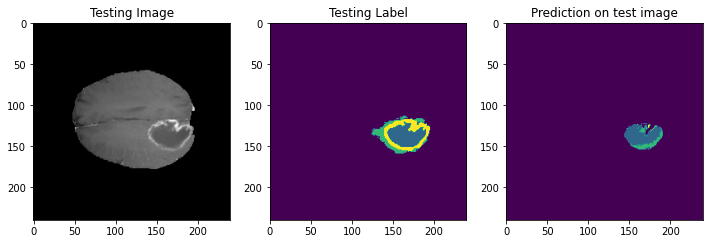

[0 1 2 3 4]


In [ ]:
n_slice = 96

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(MRI_image[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(final_ground_truth[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(final_prediction[:,:, n_slice])
plt.show()

print(np.unique(final_prediction))

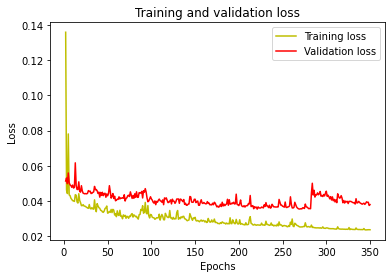

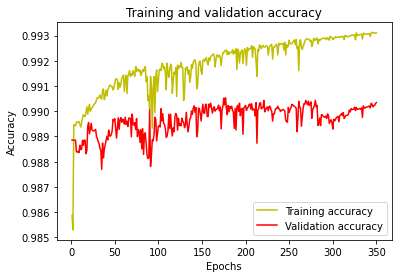

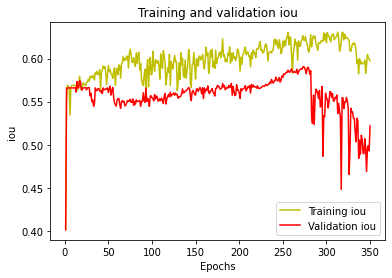

Epoches :  350


In [ ]:
import pandas as pd
csv_file_path = "/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model_history.csv"

training_history_dataframe = pd.read_csv(csv_file_path)


##################################################################


#plot the training and validation IoU and loss at each epoch
loss = np.array(training_history_dataframe['loss'])
val_loss = np.array(training_history_dataframe['val_loss'])
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = np.array(training_history_dataframe['accuracy'])
val_acc = np.array(training_history_dataframe['val_accuracy'])

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou = np.array(training_history_dataframe['iou_score'])
val_iou = np.array(training_history_dataframe['val_iou_score'])

plt.plot(epochs, iou, 'y', label='Training iou')
plt.plot(epochs, val_iou, 'r', label='Validation iou')
plt.title('Training and validation iou')
plt.xlabel('Epochs')
plt.ylabel('iou')
plt.legend()
plt.show()


print("Epoches : ",len(epochs))
#################################################